# `CNRatioAnomalyModel` Tutorial

Trey V. Wenger (c) December 2024

`CNRatioAnomalyModel` is like `CNRatioModel`, but allows for non-LTE variations in the 12CN hyperfine component optical depths, often called "hyperfine anomalies." We assume that 13CN does not suffer from similar effects. This notebook demonstrates this model and is otherwise nearly identical to the `CNRatioModel` notebook.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

from bayes_cn_hfs import HFSModel

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+0.g50000b9.dirty


In [2]:
# Get molecular data needed for simulating data
from bayes_cn_hfs import get_molecule_data

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
mol_data_13CN = get_molecule_data(
    "C-13-N", # molecule name in JPLSpec
    rot_state_lower = 0, # lower rotational state
)

## Simulating Data

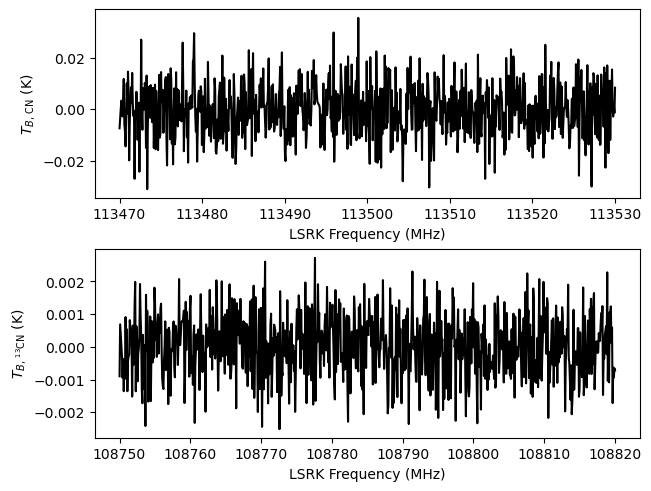

In [3]:
from bayes_spec import SpecData

# spectral axis definitions
freq_axis_12CN = np.linspace(113470, 113530, 825) # MHz
freq_axis_13CN = np.linspace(108750, 108820, 825)

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise_12CN = 0.01 # K
noise_13CN = 0.001 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_12CN = noise_12CN * np.random.randn(len(freq_axis_12CN)) # K
brightness_data_13CN = noise_13CN * np.random.randn(len(freq_axis_13CN)) # K

# Our model only expects two observations named "12CN" and "13CN"
observation_12CN = SpecData(
    freq_axis_12CN,
    brightness_data_12CN,
    noise_12CN,
    xlabel="LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
observation_13CN = SpecData(
    freq_axis_13CN,
    brightness_data_13CN,
    noise_13CN,
    xlabel="LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,^{13}\rm CN}$ (K)",
)
dummy_data = {"12CN": observation_12CN, "13CN": observation_13CN}

# Plot the dummy data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(dummy_data["12CN"].spectral, dummy_data["12CN"].brightness, 'k-')
axes[1].plot(dummy_data["13CN"].spectral, dummy_data["13CN"].brightness, 'k-')
axes[0].set_xlabel(dummy_data["12CN"].xlabel)
axes[1].set_xlabel(dummy_data["13CN"].xlabel)
axes[0].set_ylabel(dummy_data["12CN"].ylabel)
_ = axes[1].set_ylabel(dummy_data["13CN"].ylabel)

Dropping the un-observed 12CN transitions at the following frequencies (MHz):
[113123.3687 113144.19   113170.535  113191.325 ]
Dropping the un-observed 13CN transitions at the following frequencies (MHz):
[108056.1506 108057.1294 108062.9185 108076.9565 108077.2715 108091.3095
 108406.0979 108412.862  108426.889  108631.121  108636.923  108638.212
 108643.59   108644.3602 108645.064  108651.297  108657.646  108658.948
 108986.8678 109217.6017 109218.3621 109218.9506]


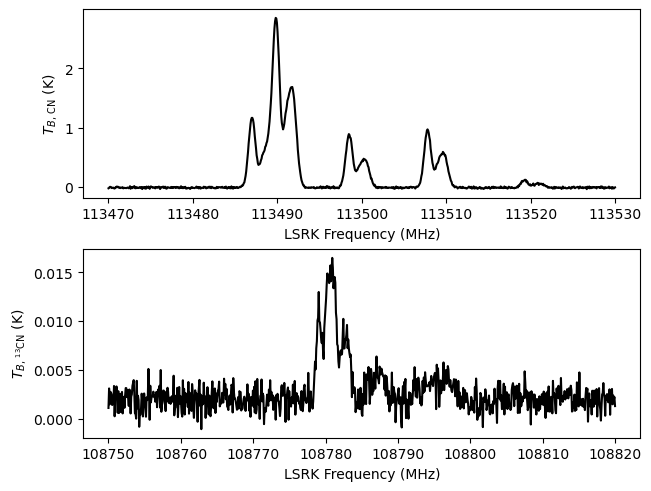

In [4]:
from bayes_cn_hfs import CNRatioAnomalyModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = CNRatioAnomalyModel(
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [14.0, 1.0], # mean and width of log10(12CN N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_ratio_13C_12C = 0.01, # width of the 13C/12C prior
    prior_log10_tex_12CN_anomaly = 0.1, # width of 12CN Tex anomaly (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

log10_tex = np.array([1.0, 1.2, 1.1])
log10_tex_12CN_comp = np.ones((len(model.mol_data_12CN['freq']), n_clouds))
for i, freq in enumerate(model.mol_data_12CN['freq']):
    if freq == 113499.643:
        log10_tex_12CN_comp[i] = np.array([0.8, 0.9, 1.0])
    elif freq == 113508.934:
        log10_tex_12CN_comp[i] = np.array([1.2, 1.4, 1.3])
    else:
        log10_tex_12CN_comp[i] = log10_tex

sim_params = {
    "log10_N_12CN": [14.0, 13.5, 14.2],
    "log10_tex": log10_tex,
    "fwhm": [3.0, 2.0, 2.5],
    "velocity": [-2.0, 0.0, 3.0],
}
sim_params_12CN = sim_params.copy()
sim_params_12CN.update({
    "log10_tex_12CN_comp": log10_tex_12CN_comp,
    "baseline_12CN_norm": [-1.0], # normalized baseline coefficients
})
sim_params_13CN = sim_params.copy()
sim_params_13CN.update({
    "ratio_13C_12C": [0.01, 0.02, 0.005],
    "baseline_13CN_norm": [2.0], # normalized baseline coefficients
})

sim_brightness_12CN = model.model["12CN"].eval(sim_params_12CN)
sim_brightness_13CN = model.model["13CN"].eval(sim_params_13CN)

# Plot the dummy data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(dummy_data["12CN"].spectral, sim_brightness_12CN, 'k-')
axes[1].plot(dummy_data["13CN"].spectral, sim_brightness_13CN, 'k-')
axes[0].set_xlabel(dummy_data["12CN"].xlabel)
axes[1].set_xlabel(dummy_data["13CN"].xlabel)
axes[0].set_ylabel(dummy_data["12CN"].ylabel)
_ = axes[1].set_ylabel(dummy_data["13CN"].ylabel)

In [5]:
# Now we pack the simulated spectra into a new SpecData instance
observation_12CN = SpecData(
    freq_axis_12CN,
    sim_brightness_12CN,
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
observation_13CN = SpecData(
    freq_axis_13CN,
    sim_brightness_13CN,
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,^{13}\rm CN}$ (K)",
)
data = {"12CN": observation_12CN, "13CN": observation_13CN}

## Model Definition

In [6]:
# Initialize and define the model
model = CNRatioAnomalyModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [14.0, 1.0], # mean and width of log10(12CN N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_ratio_13C_12C = 0.01, # width of the 13C/12C prior
    prior_log10_tex_12CN_anomaly = 0.1, # width of 12CN Tex anomaly (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Dropping the un-observed 12CN transitions at the following frequencies (MHz):
[113123.3687 113144.19   113170.535  113191.325 ]
Dropping the un-observed 13CN transitions at the following frequencies (MHz):
[108056.1506 108057.1294 108062.9185 108076.9565 108077.2715 108091.3095
 108406.0979 108412.862  108426.889  108631.121  108636.923  108638.212
 108643.59   108644.3602 108645.064  108651.297  108657.646  108658.948
 108986.8678 109217.6017 109218.3621 109218.9506]


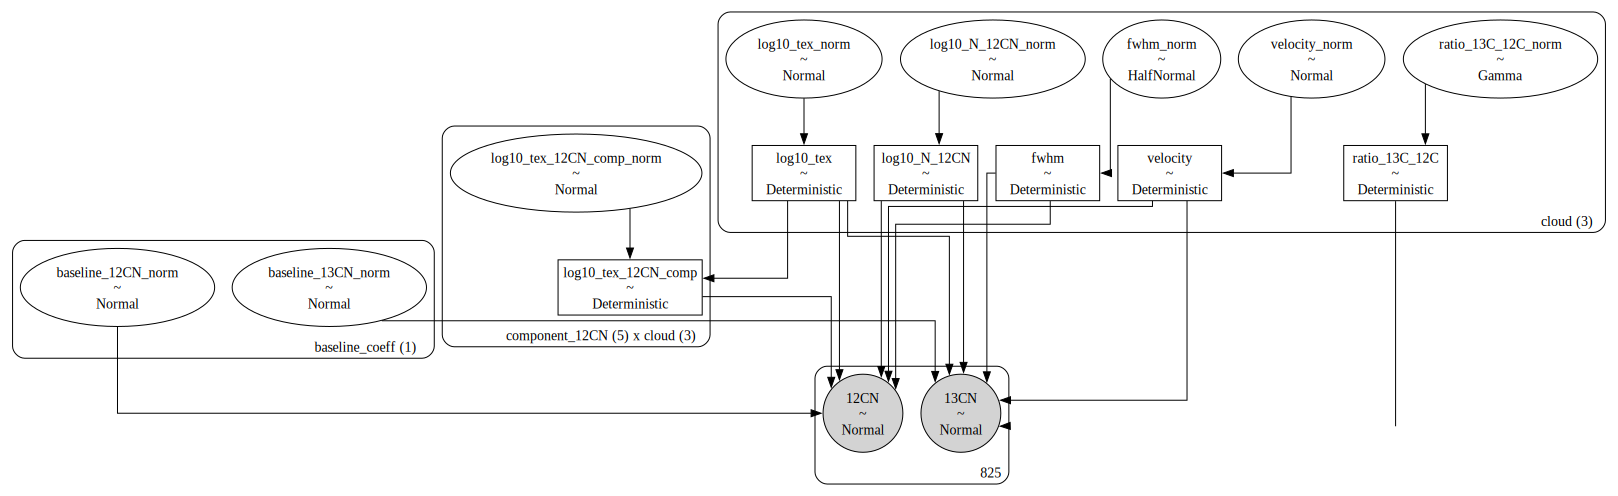

In [7]:
# Plot model graph
model.graph().render('cn_ratio_anomaly_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

      baseline_12CN_norm ~ Normal(0, 1)
      baseline_13CN_norm ~ Normal(0, 1)
       log10_N_12CN_norm ~ Normal(0, 1)
          log10_tex_norm ~ Normal(0, 1)
               fwhm_norm ~ HalfNormal(0, 1)
           velocity_norm ~ Normal(0, 1)
      ratio_13C_12C_norm ~ Gamma(2, f())
log10_tex_12CN_comp_norm ~ Normal(0, 1)
            log10_N_12CN ~ Deterministic(f(log10_N_12CN_norm))
               log10_tex ~ Deterministic(f(log10_tex_norm))
                    fwhm ~ Deterministic(f(fwhm_norm))
                velocity ~ Deterministic(f(velocity_norm))
           ratio_13C_12C ~ Deterministic(f(ratio_13C_12C_norm))
     log10_tex_12CN_comp ~ Deterministic(f(log10_tex_12CN_comp_norm, log10_tex_norm))
                    12CN ~ Normal(f(baseline_12CN_norm, log10_tex_12CN_comp_norm, log10_N_12CN_norm, log10_tex_norm, fwhm_norm, velocity_norm), <constant>)
                    13CN ~ Normal(f(baseline_13CN_norm, log10_tex_norm, ratio_13C_12C_norm, log10_N_12CN_norm, fwhm_norm, velocity_n

Sampling: [12CN, 13CN, baseline_12CN_norm, baseline_13CN_norm, fwhm_norm, log10_N_12CN_norm, log10_tex_12CN_comp_norm, log10_tex_norm, ratio_13C_12C_norm, velocity_norm]


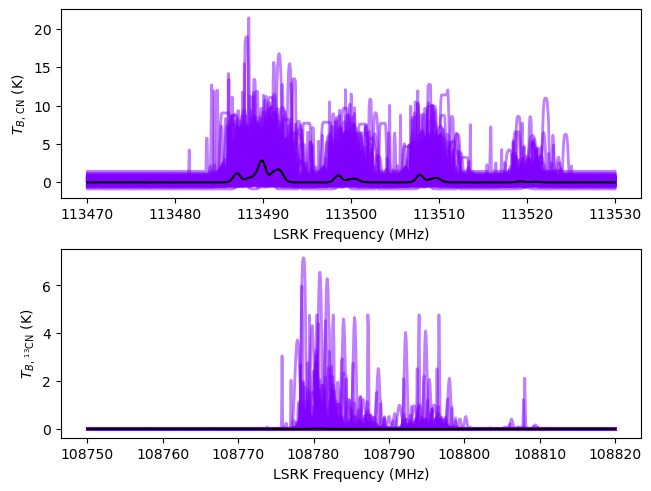

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5200
Interrupted at 5,199 [5%]: Average Loss = 2.8119e+05


Output()

Runtime: 1.34 minutes


In [11]:
# posterior samples stored in model.trace.posterior
pm.summary(model.trace.posterior, var_names=model.cloud_deterministics)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N_12CN[0],14.109,0.001,14.106,14.111,0.000,0.000,922.0,929.0,NaN
log10_N_12CN[1],14.016,0.002,14.013,14.019,0.000,0.000,1016.0,764.0,NaN
log10_N_12CN[2],13.771,0.003,13.764,13.776,0.000,0.000,927.0,768.0,NaN
log10_tex[0],0.963,0.003,0.958,0.968,0.000,0.000,1044.0,884.0,NaN
log10_tex[1],0.902,0.003,0.896,0.908,0.000,0.000,1016.0,908.0,NaN
log10_tex[2],0.949,0.023,0.908,0.996,0.001,0.001,1029.0,1058.0,NaN
fwhm[0],2.231,0.005,2.223,2.240,0.000,0.000,815.0,854.0,NaN
fwhm[1],3.202,0.010,3.183,3.220,0.000,0.000,960.0,845.0,NaN
fwhm[2],5.199,0.041,5.108,5.267,0.001,0.001,953.0,941.0,NaN
velocity[0],3.090,0.004,3.083,3.098,0.000,0.000,879.0,954.0,NaN


Sampling: [12CN, 13CN]


Output()

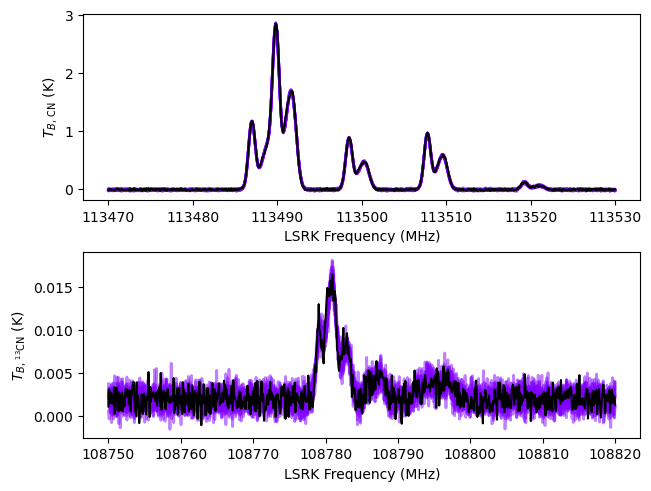

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## MCMC

This model takes a long time to sample...

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5200
Interrupted at 5,199 [5%]: Average Loss = 2.8119e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN_norm, baseline_13CN_norm, log10_N_12CN_norm, log10_tex_norm, fwhm_norm, velocity_norm, ratio_13C_12C_norm, log10_tex_12CN_comp_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 5308 seconds.


Adding log-likelihood to trace


Output()

Runtime: 90.28 minutes


In [14]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution
7 of 8 chains appear converged.


In [15]:
pm.summary(model.trace.solution_0, var_names=model.cloud_deterministics)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N_12CN[0],14.196,0.023,14.154,14.239,0.000,0.000,2444.0,3805.0,1.0
log10_N_12CN[1],14.002,0.016,13.973,14.032,0.000,0.000,2194.0,3501.0,1.0
log10_N_12CN[2],13.400,0.036,13.334,13.467,0.001,0.000,2887.0,4005.0,1.0
log10_tex[0],1.077,0.051,0.985,1.177,0.001,0.001,2639.0,4025.0,1.0
log10_tex[1],0.927,0.056,0.822,1.029,0.001,0.001,3287.0,3879.0,1.0
log10_tex[2],0.999,0.084,0.843,1.159,0.001,0.001,4018.0,4306.0,1.0
fwhm[0],2.483,0.011,2.464,2.505,0.000,0.000,4979.0,4724.0,1.0
fwhm[1],3.002,0.026,2.953,3.052,0.000,0.000,3575.0,3751.0,1.0
fwhm[2],1.945,0.045,1.861,2.030,0.001,0.001,3425.0,4019.0,1.0
velocity[0],2.992,0.003,2.987,2.996,0.000,0.000,5600.0,5805.0,1.0


Sampling: [12CN, 13CN]


Output()

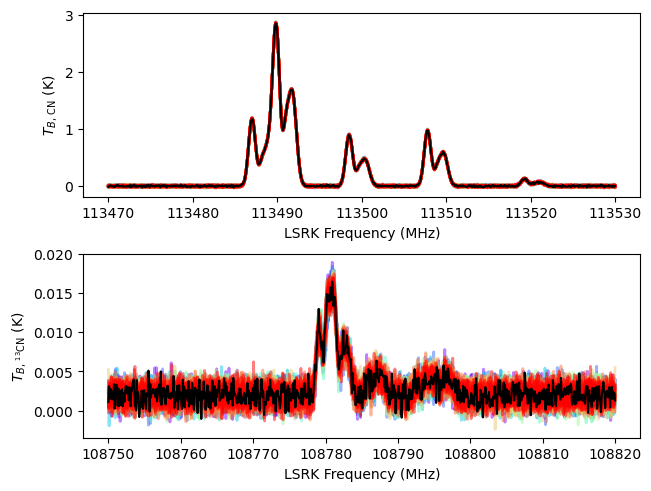

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

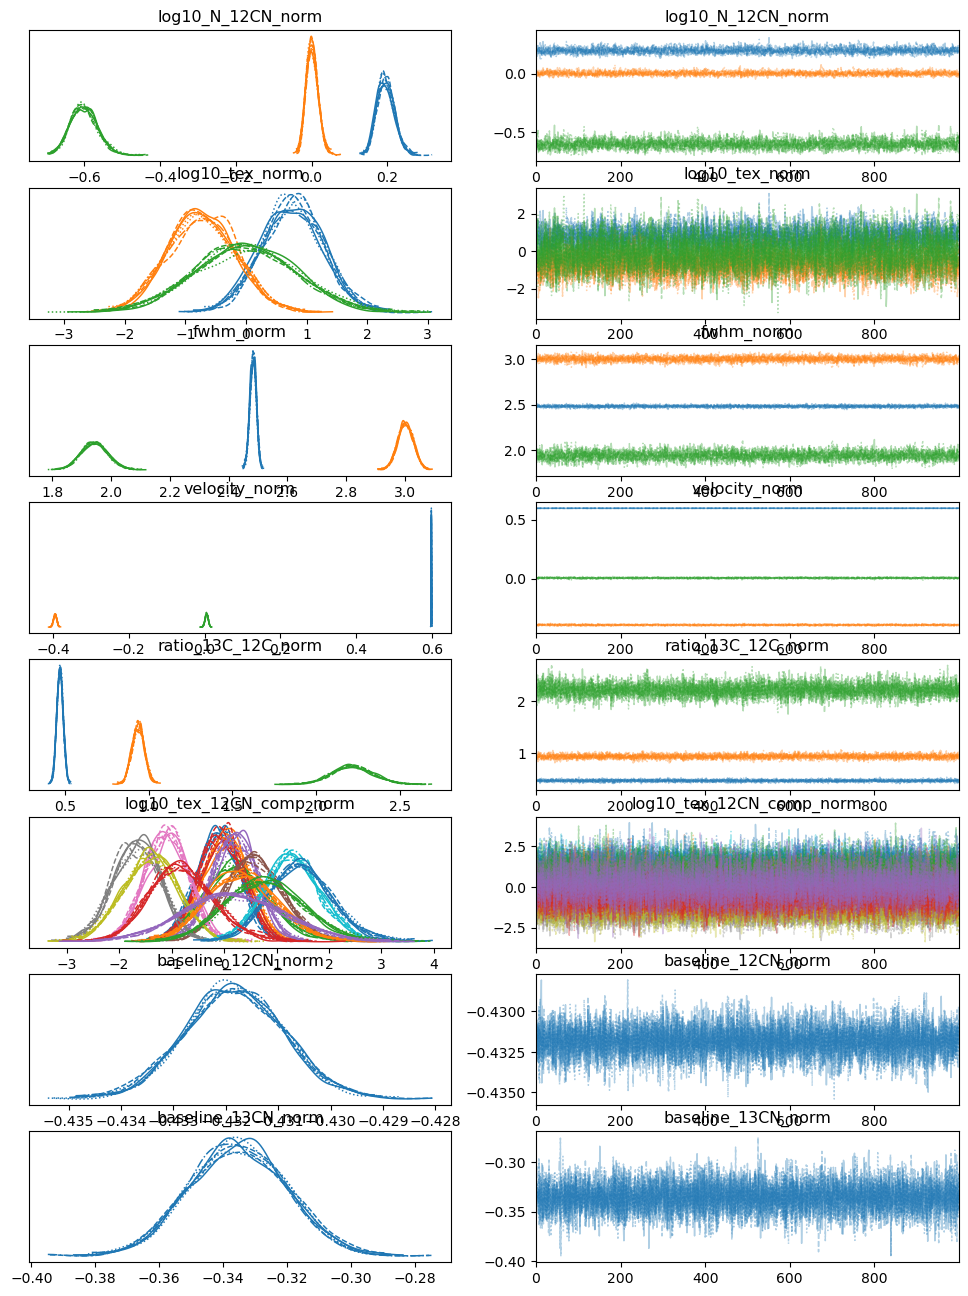

In [17]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

In [18]:
model.cloud_deterministics

['log10_N_12CN',
 'log10_tex',
 'fwhm',
 'velocity',
 'ratio_13C_12C',
 'log10_tex_12CN_comp']

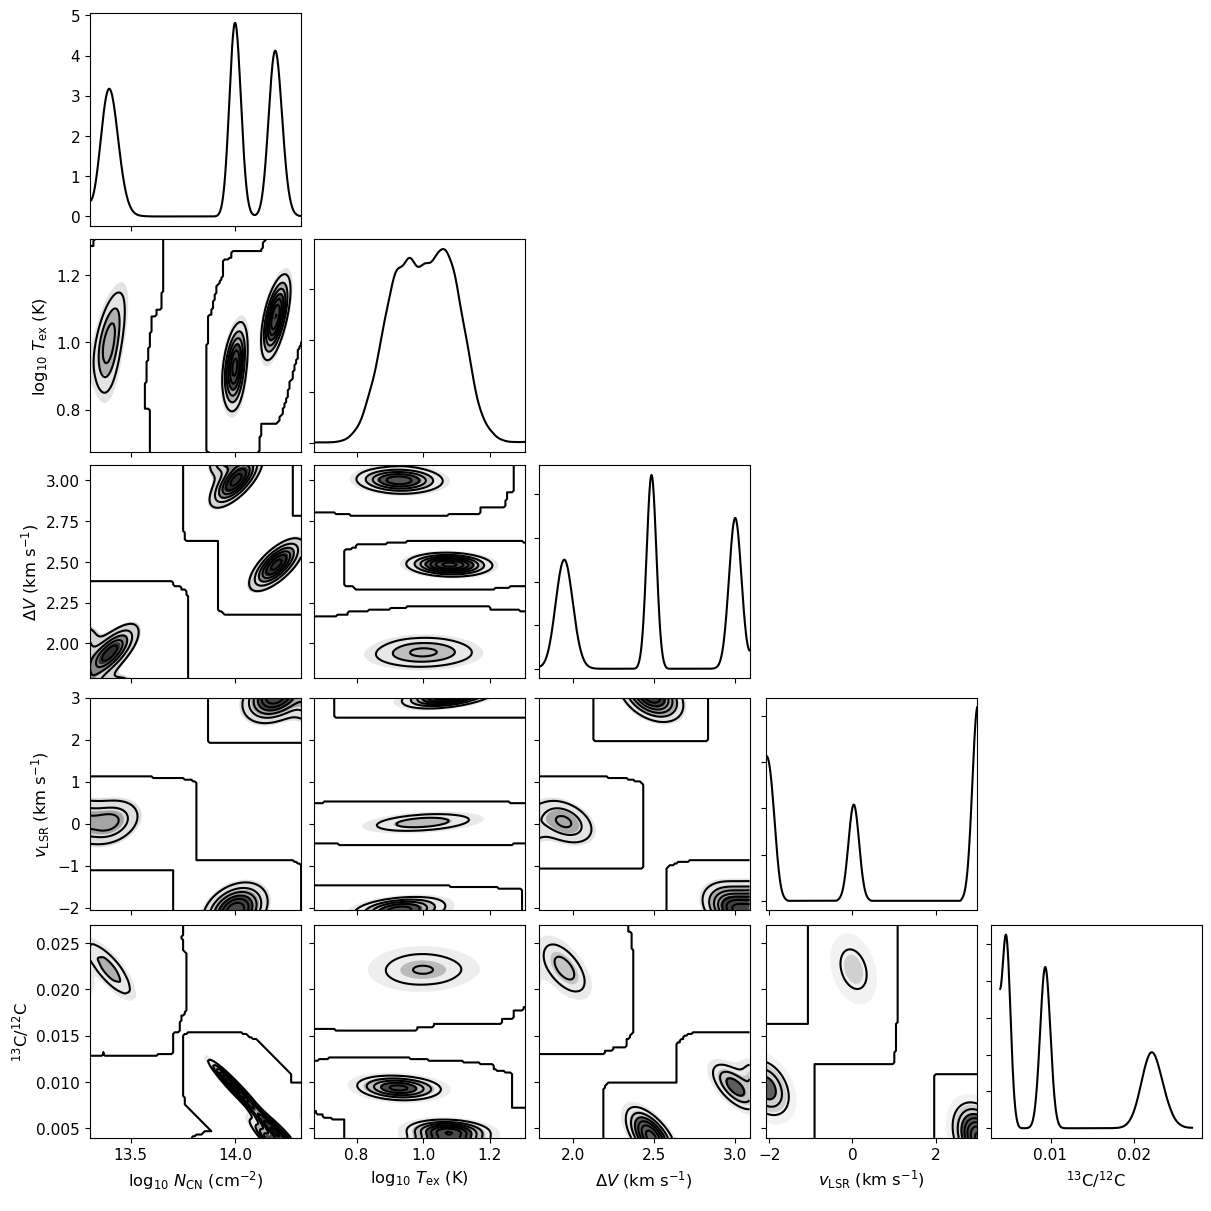

In [19]:
from bayes_spec.plots import plot_pair

var_names = [param for param in model.cloud_deterministics if "tex_12CN" not in param]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

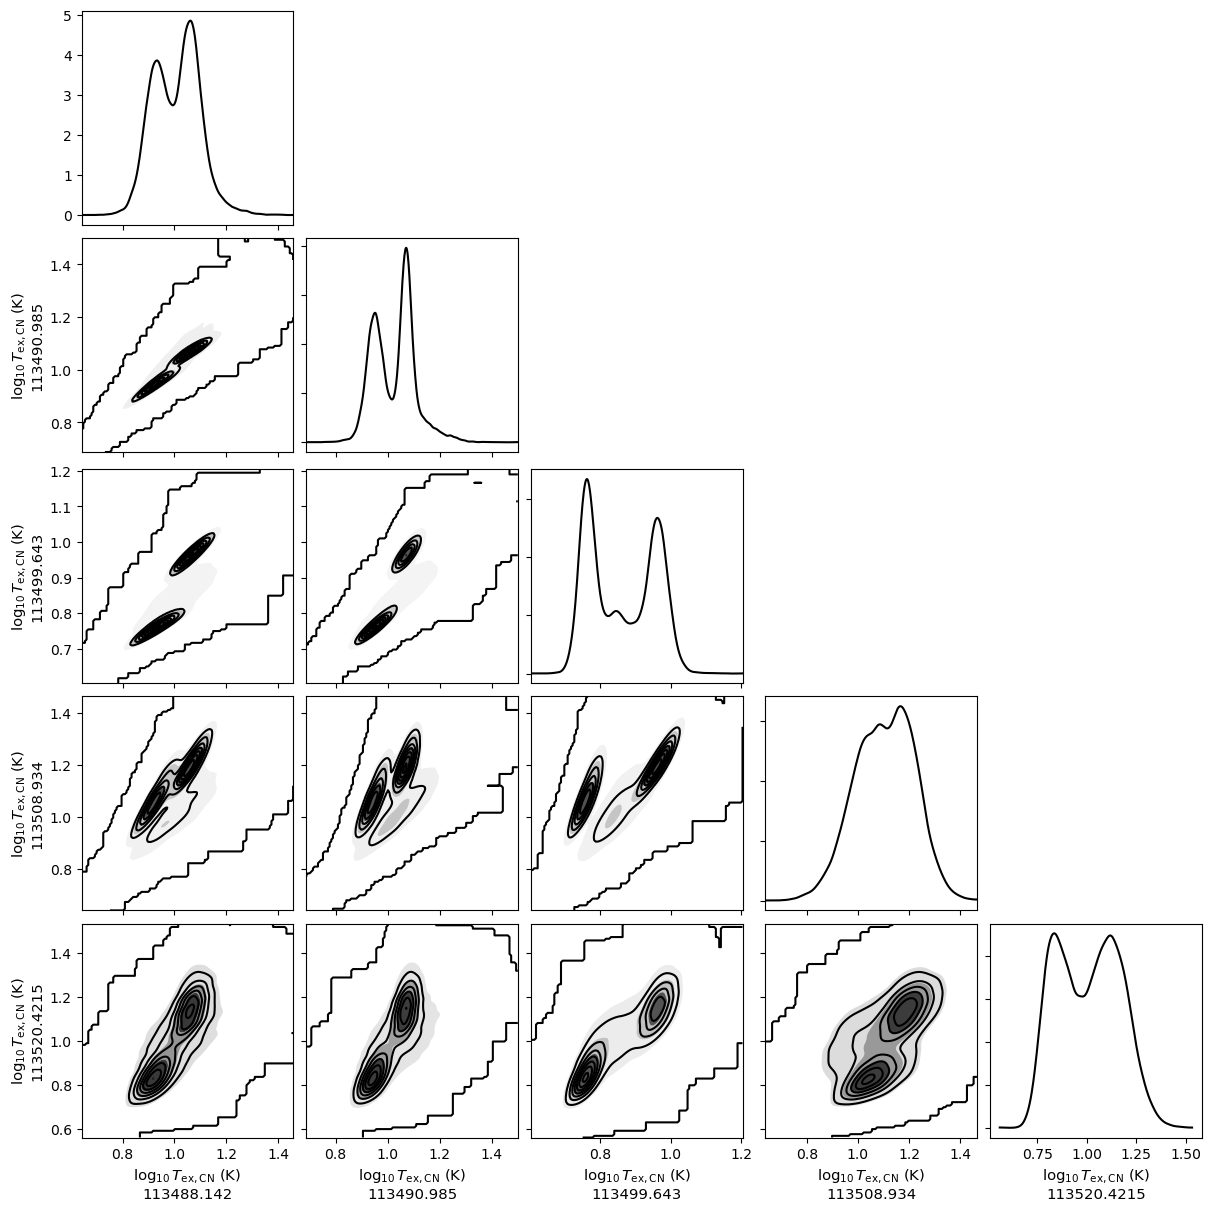

In [21]:
axes = plot_pair(
    model.trace.solution_0, # samples
    ["log10_tex_12CN_comp"], # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(12, 12)

In [22]:
point_stats = az.summary(model.trace.solution_0, var_names=model.cloud_deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -14046.824641135509


,mean,sd,hdi_16%,hdi_84%
log10_N_12CN[0],14.196,0.023,14.171,14.217
log10_N_12CN[1],14.002,0.016,13.985,14.016
log10_N_12CN[2],13.400,0.036,13.361,13.430
log10_tex[0],1.077,0.051,1.031,1.131
log10_tex[1],0.927,0.056,0.870,0.982
log10_tex[2],0.999,0.084,0.912,1.078
fwhm[0],2.483,0.011,2.474,2.495
fwhm[1],3.002,0.026,2.976,3.028
fwhm[2],1.945,0.045,1.899,1.989
velocity[0],2.992,0.003,2.989,2.994
